In [1]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
import os

import re
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
file_path  = '/content/drive/MyDrive/Deep Learning/APE'
os.chdir(file_path)

In [ ]:
# Import all methods and classes from the ape library defined in the working directory.
#from ape import *
#from tensorflow.keras.callbacks import EarlyStopping as ES
import unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from time import time

In [ ]:
!pip install tensorflow_text
import tensorflow_text as tf_text

     |████████████████████████████████| 4.3 MB 30.8 MB/s 


In [ ]:
#!unzip TrainDevReleased.zip

In [ ]:
data_dir = os.path.abspath('TrainDevReleased')
data_dir

'/content/drive/My Drive/Deep Learning/APE/TrainDevReleased'

## Preprocessing Data
The chinese language has it peculiarities:
- There are usually no space demarcations between words as chinese text is a essentially a pictogram (though in this dataset, spaces were included to retain meaning of sentence).
- Each word (symbol) is made up of smaller units called radicals.
- The english representation of a word in chinese (symbol) can be represented by several symbols arranged in a particular order. To separate these symbols is to lose the meaning of the word in the context.

Due to this, we simply preprocess the chinese dataset by removing unwanted characters that were noticed to exist within the dataset, split the characters where spaces can be found, attach a 'start' and 'end' tag to the beginning and end of the text.

The english counterpart were processed the same way as the other language pairs (i.e. English/Spanish).

Then, we tokenize the data limiting the vocabulary size to 22000 for chinese and 18000 for english. We removed any unwanted punctuatiion or symbol from the data before tokenization. This tokenization converts each word in the sentence to a unique integer value. it returns a list of list (all sentences) of integers (all words in each sentence). This list is then passed to a pad_sequence method that pads each list (list of integers) with zeros and returns a tensor object. This padding makes all the sentences have equal length as required by the model.



In [ ]:
# We extract all the sentences from the data file appropriately
train_files = ['APETask_en-zh_train.tok.tc.src',
               'APETask_en-zh_train.tok.tc.mt',
               'APETask_en-zh_train.tok.tc.pe']

dev_files = ['APETask_en-zh_dev.tok.tc.src',
             'APETask_en-zh_dev.tok.tc.mt',
             'APETask_en-zh_dev.tok.tc.pe']
# Create list to save all the datasets appropriately:
train_source = [] # training data for source sentences
train_target = [] # training data for machine translated sentences
train_pe = [] # training data for human post edited sentences
dev_source = [] # development data for source sentences.
dev_target =[] # development data for machine translated sentences
dev_pe = [] # development data for human post edited sentences.

# Go through both training file and development file:
for train, dev in zip(train_files, dev_files):
  # get training path
  train_path = os.path.join(data_dir, train)
  # get path to development file
  dev_path = os.path.join(data_dir, dev)

  # open file and append them to the appropriate list:
  with open(train_path, 'rb') as f:
    # If path ends with source append to train_source list:
    if train_path.endswith('src'):
      train_source.extend(f.readlines())
    # If path ends with target, append to train_target list:
    elif train_path.endswith('mt'):
      train_target.extend(f.readlines())

    # Else append to train_pe list:
    else:
      train_pe.extend(f.readlines())
  # Do as above for development dataset:
  with open(dev_path, 'rb') as f:
    if dev_path.endswith('src'):
      dev_source.extend(f.readlines())
    elif dev_path.endswith('mt'):
      dev_target.extend(f.readlines())
    else:
      dev_pe.extend(f.readlines())

train_source = [tr.decode('utf-8').lower() for tr in train_source]
train_target = [tr.decode('utf-8').lower() for tr in train_target]
train_pe = [tr.decode('utf-8').lower() for tr in train_pe]
dev_source = [dev.decode('utf-8').lower() for dev in dev_source]
dev_target = [dev.decode('utf-8').lower() for dev in dev_target]
dev_pe = [dev.decode('utf-8').lower() for dev in dev_pe]


print('Source: ',train_source[-1])
print('MT output: ',train_target[-1])
print('Human pe: ', train_pe[-1])

print()
print('Source: ',dev_source[-1])
print('MT output: ',dev_target[-1])
print('Human pe: ', dev_pe[-1])

Source:  during the video , ronson and mars get their hairs in perm curlers at a salon and their shoes shined .

MT output:  在 录像 中 ， 罗森 和 火星 的 头发 在 沙龙 和 他们 的 鞋子 闪闪发亮 。

Human pe:  视频 中 ， 罗森 （ ronson ） 和 火星 （ mars ） 在 沙龙 里 用 烫发 器 卷发 ， 也 把 鞋子 擦亮 了 。


Source:  the streets , sidewalks , balconies and windows were thronged with mourners .

MT output:  街道 、 人行道 、 阳台 和 窗户 上 挤满 了 悼念 者 。

Human pe:  街道 、 人行道 、 阳台 和 窗户 上 挤满 了 悼念 者 。



In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


def preprocess_eng(sent):
  sentences = []
  for w in sent:
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/
    # python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"(['?.!,\"])", r" \1 ", w)
    w = re.sub(r"('[a-z]{1}\s)",r" \1",w)
    # replace several spaces with one space
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r'[^a-zA-Z?.!,]+', " ", w)
    w = re.sub(r'\\n', '',w)
    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    sentences.append(w)
  return sentences


def preprocess_chinese(sent):
  sentences = []
  for w in sent:
    w = unicode_to_ascii(w)
    #w = re.sub(r'[" "]+', "", w)
    w = re.sub(r"[()·]+", "", w)
    w = re.sub(r"、", ', ', w)
    w = re.sub(r'。','.', w)
    w = re.sub('\\n','',w)
    w = re.sub(r'[\"\']','',w)
    w = w.rstrip().strip()
    #w = " ".join(list(w))  # add the space between words
    w = '<start> ' + w + ' <end>'
    sentences.append(w)
  return sentences

In [ ]:
# Preprocess all sentences in the training data.
train_source = preprocess_eng(train_source)
train_target = preprocess_chinese(train_target)
train_pe = preprocess_chinese(train_pe)

dev_source = preprocess_eng(dev_source)
dev_target = preprocess_chinese(dev_target)
dev_pe = preprocess_chinese(dev_pe)

We define a tokenizer object for each language 

In [ ]:
eng_vocab_size = 18000
ch_vocab_size = 22000
chinese_tokenizer = Tokenizer(
    num_words= ch_vocab_size,
    filters='"#%&()*+\'/:=@[\\]^_{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token='[UNK]'
)
english_tokenizer = Tokenizer(
    num_words=eng_vocab_size, filters='"#%&()*+\'/:=@[\\]^_{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token='[UNK]'
)

We fit the tokenizers to the corresponding language text.

In [ ]:
english_tokenizer.fit_on_texts(train_source)
chinese_tokenizer.fit_on_texts(train_target+train_pe)

During tokenization, the index '0' in the vocabulary dictionary (a property of the tokenizer object) is usually reserved. Therefore, we map this index to the 'pad' tag since we used the number '0' to pad all sentences earlier.



In [ ]:
english_tokenizer.word_index['<pad>'] = 0
english_tokenizer.index_word[0] = '<pad>'

chinese_tokenizer.word_index['<pad>'] = 0
chinese_tokenizer.index_word[0] = '<pad>'

After fitting tokenizer on datasets, we convert all sentences to a list of integer values. We do this for the src, mt and hpe sentences for both languages.

In [ ]:
train_src = english_tokenizer.texts_to_sequences(train_source)
train_mt = chinese_tokenizer.texts_to_sequences(train_target)
train_hpe = chinese_tokenizer.texts_to_sequences(train_pe)

dev_src = english_tokenizer.texts_to_sequences(dev_source)
dev_mt = chinese_tokenizer.texts_to_sequences(dev_target)
dev_hpe = chinese_tokenizer.texts_to_sequences(dev_pe)

Pad sequences with '0'.

In [ ]:
# Pad each vector to the max_length of the sentences
# If you do not provide a max_length value, pad_sequences calculates it automatically
train_src = tf.keras.preprocessing.sequence.pad_sequences(train_src, padding='post')
train_mt = tf.keras.preprocessing.sequence.pad_sequences(train_mt, padding='post')
train_hpe = tf.keras.preprocessing.sequence.pad_sequences(train_hpe, padding='post')


dev_src = tf.keras.preprocessing.sequence.pad_sequences(dev_src, padding='post')
dev_mt = tf.keras.preprocessing.sequence.pad_sequences(dev_mt, padding='post')
dev_hpe = tf.keras.preprocessing.sequence.pad_sequences(dev_hpe, padding='post')


In [ ]:
train_src.shape

(7000, 38)

Now, we define the train and test dataset.

In [ ]:
from sklearn.utils import shuffle

#train_src, train_mt, train_hpe = shuffle(train_src[1:], train_mt[1:], train_hpe[1:], random_state=27)

test_src, test_mt = train_src[6000:], train_mt[6000:]
test_hpe = train_pe[6000:]
train_src, train_mt, train_hpe = train_src[:6000], train_mt[:6000], train_hpe[:6000]


# print(test_src.shape,test_mt.shape)
# print(len(test_hpe),train_src.shape)

In [ ]:
train_src.shape

(6000, 38)

In [ ]:
epochs = 60
TRAIN_BUFFER_SIZE = len(train_src)
BATCH_SIZE = 64
TEST_BUFFER_SIZE = len(test_src)

# This Dataset class shuffles the data and precreates batches for it.
dataset = tf.data.Dataset.from_tensor_slices((train_src, train_mt, train_hpe)).shuffle(TRAIN_BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)



## Model Definition
Since the dataset has a different preprocessing technique, we redefine the whole model to suit this peculiarity. We remove the text processors found in the other definintion of the model. The preprocess method call within the train_step function is also removed.

In [ ]:
# Define full model

class Ape(tf.keras.Model):
  def __init__(self,units,embedding_dim, att_units, linear_units,src_vocab_size, mt_hpe_vocab_size, dropout=0.2):
    # initialize with parent class:
    super(Ape, self).__init__()

    # initialize encoder:
    self.encoder  = Encoder(units,embedding_dim,src_vocab_size,
                            mt_hpe_vocab_size,dropout= dropout)

    # Initialize decoder:
    self.decoder  = Decoder(units, att_units, linear_units, mt_hpe_vocab_size, 
                            embedding_dim,dropout =dropout)

  # Define the customized training function:
  @tf.function
  def train_step(self, data):
    # Unpack the data.
    src , mt, hpe = data

    # Preprocess source, mt and hpe sentences:
    #src , mt , hpe = self._preprocess(src, mt , hpe)
    
    max_target_length = tf.shape(hpe)[1]
   
    # Set loss to 0.0
    loss = tf.constant(0.0)

    # Set the first input to the decoder model to the '[START]' token which is the first element of each sentence:
    dec_input = hpe[:,0]

    with tf.GradientTape() as tape:       
      # Pass the source and machine translated sentences to the encoder as inputs.
      # we use the returned hidden state of the encoder to initialize the decoder's hidden state:
      src_encode , mt_encode , dec_hidden = self.encoder(src, mt)

      # Use for loop to iterate through each word as we predict the next word:
      for i in range(1,max_target_length):
      # Make predictions
        # Pass dec_input (serves as previous words), dec_hidden and the encoded src and mt to the decoder.
        predictions , dec_hidden = self.decoder(dec_input, dec_hidden, src_encode, mt_encode)

        # Calculate the loss
        loss  = loss + self.loss(hpe[:,i],predictions)

        # Using teacher forcing:
        # Teacher forcing continually feeds the next correct word in the real hpe (target) sentences to the model
        # instead of passing what the model predicted back into the model.
        dec_input = hpe[:, i]

        
      
      # Average the loss over all non padding tokens.
      average_loss = loss / tf.cast(max_target_length, tf.float32)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}
    

Model is initialized.

In [ ]:
embedding_dim = 512
hidden = 1024
att_units = 256
linear_units = 512


ape = Ape(hidden,embedding_dim, att_units, linear_units, eng_vocab_size, ch_vocab_size, dropout=0.2)

# Configure the loss and optimizer
ape.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
# Initialize the learning rate for the model.
initial_learning_rate = 0.001
# We schedule a learning rate for every epoch using the formula below:
# For every epoch, learning rate is reduced using this formula.
decay = initial_learning_rate / epochs

# We use a time based decay to schedule the learning rate which will be appropriate for online learning.
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)


# Now, create a checkpoint manager that saves the model and its parameters during training to file.
# This will enable the model to be loaded later for prediction task or further training.
checkpoint_path = "/content/drive/MyDrive/Deep Learning/APE/checkpoints/Eng_ch_Train"
ckpt = tf.train.Checkpoint(ape)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

#start_epoch = 0
if ckpt_manager.latest_checkpoint:
  # If you retrain this model then uncomment the next line of code:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  #start_epoch = int(ckpt_manager.checkpoints[0].split('-')[-1])

  #restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)
#ckpt.restore(ckpt_manager.checkpoints[0])#

Train baseline model here:

In [ ]:
from time import time 
# start_time = time()
# ape.fit(dataset,epochs=epochs,
#         callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)],)
# #,EarlyStopping(monitor='batch_loss',patience=3,verbose=1)
# finish_time = time()

In [ ]:
      #18 mins for first 5 epochs, 73,52 mins for the another 22 epochs.
#print(f'Training time : {(finish_time - start_time)/60 } minutes.')
# ckpt_manager.save()


In [ ]:
# Function decodes sentences to the corresponding unicode readable text.
def decode(sent):
  sentences = []
  for s in sent:
    sentences.append(s.decode('utf-8'))
  return sentences


class APETranslator(tf.Module):
  def __init__(self,
               encoder, decoder, 
               mt_hpe_text_processor,vocab_size):
    # Initialize encoder, decoder, src_processor, mt_hpe_processor:
    self.encoder = encoder
    self.decoder = decoder
    self.mt_hpe_text_processor = mt_hpe_text_processor

    # We initialize a string look up that will convert tokens to their equivalent words from the src and mt vocabulary:
    # We use the StringLookup class.
    # self.output_token_string_from_index = (
    #     tf.keras.layers.experimental.preprocessing.StringLookup(
    #         vocabulary= mt_hpe_text_processor.get_vocabulary(),
    #         invert=True))

    # The output should never generate padding, unknown, or start.
    # Therefore, get the index of '', '[UNK]' and '[START]' from the vocabulary:
    # index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
    #     vocabulary= mt_hpe_text_processor.get_vocabulary())
    # token_mask_ids = index_from_string(['',
    #                                     '[UNK]',
    #                                     '[START]']).numpy()

    token_mask_ids = np.array([self.mt_hpe_text_processor.word_index['[UNK]'],
                               self.mt_hpe_text_processor.word_index['<start>'],
                               self.mt_hpe_text_processor.word_index['<pad>']])

    # Create a token mask by first creating an array of tokens (vocabulary) and then initialize all to False
    # Set the indexes of the '', '[UNK]' and '[START]' to True:
    token_mask = np.zeros(vocab_size, dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True

    # set as a property of the class
    self.token_mask = token_mask

    # Get the index of the '<start>' and '<end>' tokens:
    
    self.start_token = self.mt_hpe_text_processor.word_index['<start>']
    self.end_token = self.mt_hpe_text_processor.word_index['<end>']

  def sample(self, logits, temperature):

    # Add 2 new axis to the token_mask shape
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

    # Set the logits for all masked tokens ('','[START]', '[UNK]') to -inf, so they are never chosen.
    # The logits (shape== (batch_size, vocab_size) here represents the independent probabilities of each word in the vocabulary.
    logits = tf.where(token_mask, -np.inf, logits)
    # If temperature is 0, get the max logit argument for each sample in the batch:
    # This argument represents the index of the word with the highest independent probability.
    if temperature == 0.0:
      new_tokens = tf.argmax(logits, axis=-1)
    # Else, sample from the independent probabilities of the logit:
    else: 
      logits = tf.squeeze(logits, axis=1)
      new_tokens = tf.random.categorical(logits/temperature,
                                          num_samples=1)
    return new_tokens

  def single_post_edit(self, src, mt, max_length=50, temperature=1.0):
    result = []
    if type(src) == np.ndarray and type(mt) == np.ndarray:
      src, mt = tf.expand_dims(src,0), tf.expand_dims(mt, 0)
    elif type(src) == list and type(mt) == list:
      src, mt = tf.convert_to_tensor(src) , tf.convert_to_tensor(mt)
    else:
      print('Please, use either an numpy array or list for both source and mt inputs.')

    src, mt, dec_hidden= self.encoder(src, mt)
    dec_input = tf.fill((1,),self.start_token)
    #tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    for i in range(max_length):
        # TensorShape([1, 1, 15000]), TensorShape([1, 1024]))
        predictions, dec_hidden = self.decoder(dec_input, dec_hidden, src, mt)

        predicted_id = tf.random.categorical(tf.squeeze(predictions,1)/temperature, 1)[0][0].numpy()
        #print(predicted_id)
        
        result.append(self.mt_hpe_text_processor.index_word[tf.cast(predicted_id, tf.int64).numpy()])

        if predicted_id == self.end_token:
            return ' '.join(result[:-1])

        dec_input = tf.fill((1,), predicted_id)
    
    return ' '.join(result)

  #@tf.function
  def post_edit(self, src, mt, max_length=70,temperature=1.0):

    batch_size = tf.shape(src)[0]

    # Encode inputs:
    src_enc, mt_enc , dec_state = self.encoder(src, mt)

    # Initialize the decoder
    new_tokens = tf.fill((batch_size,), self.start_token)


    # Initialize the accumulators for the decoder output:
    result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
    # Initialize a tf array that tracks the end_token of all samples in the batch:
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    #print(f'outside loop: {new_tokens.shape}', dec_state.shape)

    for t in tf.range(max_length):
      # Pass through decoder model:
      #print('yes')
      #print('Beginning of loop',new_tokens.shape)
      dec_result, dec_state = self.decoder(new_tokens, dec_state, src_enc, mt_enc)
      #print('NO')
      new_tokens = self.sample(dec_result, temperature)
      #print('After self.sample',new_tokens.shape)
      # If a sequence produces an `end_token`, set it `done`
      done = done | (new_tokens == self.end_token)
      # Once a sequence is done it only produces 0-padding.
      new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

      # Collect the generated tokens
      result_tokens = result_tokens.write(t, new_tokens)
      new_tokens = tf.squeeze(new_tokens)

      if tf.reduce_all(done):
        break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = result_tokens.stack()
    result_tokens = tf.squeeze(result_tokens, -1)
    result_tokens = tf.transpose(result_tokens, [1, 0])
    #print(result_tokens.shape)

    result_text = self.mt_hpe_text_processor.sequences_to_texts(result_tokens.numpy())
    result_text = tf.strings.regex_replace(result_text, '<pad>','')
    result_text = tf.strings.strip(result_text)

    # Convert string to readable format (unicode):
    result_text = decode(result_text.numpy())

    return {'text': result_text}


def get_translator(model,text_processor,vocab_size):
  return APETranslator(model.encoder, model.decoder, text_processor,vocab_size)



In [ ]:
translator = get_translator(ape, chinese_tokenizer,ch_vocab_size)

In [ ]:
translator.single_post_edit(test_src[1], test_mt[1])

'它们 有 高度 偏心 [UNK] ， 将 湖泊 的 轨道 ， 一般来说 ， 近日点 在 内行星 的 轨道 内 ， 一般来说 ， 近日点 在 内行星 的 轨道 ， 一般来说 ， 近日点 在 内行星 的 轨道 [UNK] ， 一般来说 ， 近日点 在 内行星 的 轨道 内 ， 将 它 [UNK] 冥王星'

In [ ]:
import pandas as pd
# Store test predictions here:
# predictions = []
# size = 500
# for i in range(0,len(test_src),size):
#   pred = translator.post_edit(test_src[i:size], test_mt[i:size])['text']
#   predictions.extend(pred)
#   size += 500

# len(predictions)

In [ ]:
def remove_tags(sent):
  sentences = []
  for s in sent:
    s = s.replace('<start>','')
    s = s.replace('<end>','')
    sentences.append(s.strip())
  return sentences

# df = pd.DataFrame({'Source': remove_tags(train_source[6000:]), 'Machine Translation ouput': remove_tags(train_target[6000:]),
#                    'Machine Post Edit (APE)': predictions, 'Human Post-Edit (HPE)': remove_tags(test_hpe)})

# df.to_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Batch_APE_Eng_Ch_Result.csv')
# df.head(10)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Batch_APE_Eng_Ch_Result.csv')
df.head(10)

,Unnamed: 0,Source,Machine Translation ouput,Machine Post Edit (APE),Human Post-Edit (HPE)
0,0,he appears as a short hunched green skinned hu...,"他 看起来 像 一个 身材 短长 的 绿色 皮肤 的 人 , 脑部 暴露 了 .",他 看起来 像是 矮小 驼背 且 绿色 皮肤 的 人形 哥萨克人 上 .,他 看起来 像是 矮小 驼背 且 绿色 皮肤 的 人形 生物 ， 大脑 裸露 在外 .
1,1,"they have highly eccentric orbits , generally ...",它们 有 高度 偏心 的 轨道 ， 通常 是 内行星 轨道 内 的 一个 环 螺旋 和 远 ...,它们 有 高度 偏心 的 轨道 ， 一般来说 ， 近日点 在 内行星 的 轨道 内 ， 灰色...,它们 有 高度 偏心 的 轨道 ， 一般来说 ， 近日点 在 内行星 的 轨道 内 ， 远日...
2,2,"it eats forage fish , and occasionally squid a...","它 吃 饲料 鱼 , 偶尔 吃 鱿鱼 和 乌贼 .",它 吃 了 该省 的 各种 分支 和 鱿鱼 .,它 吃 草食 鱼类 ， 偶尔 吃 乌贼 和 墨鱼 .
3,3,they find the machina fini mundi and battle th...,他们 找到 了 马奇娜 菲尼 蒙迪 ， 并 与 卫士 们 战斗 .,他们 找到 了 马奇娜 菲尼 蒙迪 ， 并 与 卫士 们 战斗 .,他们 找到 了 马奇娜 菲尼 蒙迪 ， 并 与 卫士 们 战斗 .
4,4,"jawbreaker broke up soon afterwards , with sch...","此后 不久 , 乔布 勒 分手 了 , 施瓦辛格 组成 了 巴西 的 埃 莫 波段 喷气机 .",不久 之后 ， 新 就 解散 了 ， 《 圣杯 的 情绪 摇滚乐 队 jets to . l...,不久 之后 ， jawbreaker 就 解散 了 ， schwarzenbach 组建 了...
5,5,booster gold goes to the middle east knocks ou...,推销员 金去 中东 击退 士兵 ， 在 超人 到达 前 拯救 露易丝 和 琼恩 .,“ 金色 助推器 ” 去 中东 击倒 了 赛车 .,“ 金色 助推器 ” 去 中东 击倒 士兵 ， 并 在 超人 到达 那里 之前 拯救 了 路...
6,6,"grantland rice rode out of durham , north caro...",格兰特 兰 稻米 和 俄勒冈州 一起 从 北卡罗来纳州 的 达勒姆 出发 .,格兰特 兰 赖斯 队 成功 击败,"格兰特 兰 赖斯 队 成功 击败 杜伦队 , 北卡罗来纳 队 和 俄勒冈 队 ."
7,7,"j . hoyle s mill in irwell street , which empl...",& j . hoyle s 在 irwell street 的 mill 使用 电力 编织...,以及 牛科 建筑 在 春季 中 的 得分 庆祝 死 ， 右侧 在 上校 到 后方 和 西班牙...,＆ j . hoyle s mill 位于 irwell street 的 工厂 ， 该 ...
8,8,four tornadoes touched down in tennessee and e...,四只 龙卷风 在 田纳西州 和 肯塔基州 南部 的 极端 地区 落下 .,四场 龙卷风 袭击 了 田纳西州 和 肯塔基州 最 南部 .,四场 龙卷风 袭击 了 田纳西州 和 肯塔基州 最 南部 .
9,9,"during the american civil war , the choctaw in...",在 美国 内战 期间 ， 俄克拉何马州 和 密西西比州 的 乔克 托人 大多 站 在 美国 ...,在 美国 内战 期间 ， 俄克拉荷马州 和 密西西比州 的 乔克 托人 大多 与 中国 角 ...,在 美国 内战 期间 ， 俄克拉荷马州 和 密西西比州 的 乔克 托人 大多 与 美利坚 联...


## Training Development set in Batch and Online Learning Mode
First , we update the parameters of the development set in the batch mode. Then, we make a copy of the pretrained model and update in the online mode.

### Batch Learning Mode.
We load the model into memory and train on 950 develpment samples. We use this because thats what was used for the online training below. We are going to train this model for 8 epochs. We also use a time-based learning rate schedule and early stopping to prevent the model from overfitting on the development set.

Note: The online training was done before batch training in this notebook and was checkpointed (parameters saved to storage) at least after 950 samples.

In [ ]:
#Make similar for the test dataset:
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_src[:950], dev_mt[:950], dev_hpe[:950])).shuffle(TEST_BUFFER_SIZE)
dev_dataset = dev_dataset.batch(BATCH_SIZE)
dev_dataset = dev_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
start_time = time()
ape.fit(dev_dataset,epochs=8,
        callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1),EarlyStopping(monitor='batch_loss',patience=4,verbose=1)])
finish_time = time()

Epoch 1/8

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0009916534181684256.
15/15 [==============================] - 26s 2s/step - batch_loss: 0.1805
Epoch 2/8

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009916368908869106.
15/15 [==============================] - 27s 2s/step - batch_loss: 0.1330
Epoch 3/8

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0009916038337316017.
15/15 [==============================] - 27s 2s/step - batch_loss: 0.0985
Epoch 4/8

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0009915542475289506.
15/15 [==============================] - 26s 2s/step - batch_loss: 0.0746
Epoch 5/8

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0009914881331053553.
15/15 [==============================] - 27s 2s/step - batch_loss: 0.0555
Epoch 6/8

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0009914054912871573.
15/15 [==============================] - 26s 2s/step - batch

In [ ]:
# Store test predictions here:
predictions = []
size = 500
for i in range(0,len(test_src),size):
  pred = translator.post_edit(test_src[i:size], test_mt[i:size])['text']
  predictions.extend(pred)
  size += 500



In [ ]:
df = pd.DataFrame({'Source': remove_tags(train_source[6000:]), 'Machine Translation ouput': remove_tags(train_target[6000:]),
                   'Machine Post Edit (APE)': predictions, 'Human Post-Edit (HPE)': remove_tags(test_hpe)})

df.to_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Batch_update_APE_Eng_Ch_Result.csv')
df.head(10)

,Source,Machine Translation ouput,Machine Post Edit (APE),Human Post-Edit (HPE)
0,he appears as a short hunched green skinned hu...,"他 看起来 像 一个 身材 短长 的 绿色 皮肤 的 人 , 脑部 暴露 了 .",他 它 像 一个 人口 的 延伸 有 .,他 看起来 像是 矮小 驼背 且 绿色 皮肤 的 人形 生物 ， 大脑 裸露 在外 .
1,"they have highly eccentric orbits , generally ...",它们 有 高度 偏心 的 轨道 ， 通常 是 内行星 轨道 内 的 一个 环 螺旋 和 远 ...,它们 拥有 这些 庙宇 里 的 一个 竖琴 ， 居住 着 用 用 倾角 场 ， 但 在 春天...,它们 有 高度 偏心 的 轨道 ， 一般来说 ， 近日点 在 内行星 的 轨道 内 ， 远日...
2,"it eats forage fish , and occasionally squid a...","它 吃 饲料 鱼 , 偶尔 吃 鱿鱼 和 乌贼 .","它 吃 鱼类 吃 乌贼 , 皮肤 , 密谋 和 鳄鱼 .",它 吃 草食 鱼类 ， 偶尔 吃 乌贼 和 墨鱼 .
3,they find the machina fini mundi and battle th...,他们 找到 了 马奇娜 菲尼 蒙迪 ， 并 与 卫士 们 战斗 .,他们 找到 了 新南威尔士州 战斗 一起 .,他们 找到 了 马奇娜 菲尼 蒙迪 ， 并 与 卫士 们 战斗 .
4,"jawbreaker broke up soon afterwards , with sch...","此后 不久 , 乔布 勒 分手 了 , 施瓦辛格 组成 了 巴西 的 埃 莫 波段 喷气机 .",不久 ， 击落 后 ， 在 《 癖 》 后 ， 2 后 ， 挑战 后 ， “ 化学 后 举行...,不久 之后 ， jawbreaker 就 解散 了 ， schwarzenbach 组建 了...
5,booster gold goes to the middle east knocks ou...,推销员 金去 中东 击退 士兵 ， 在 超人 到达 前 拯救 露易丝 和 琼恩 .,这 一 帮助 比赛 并 击倒 了 无能 的 回归 .,“ 金色 助推器 ” 去 中东 击倒 士兵 ， 并 在 超人 到达 那里 之前 拯救 了 路...
6,"grantland rice rode out of durham , north caro...",格兰特 兰 稻米 和 俄勒冈州 一起 从 北卡罗来纳州 的 达勒姆 出发 .,"格兰特 兰 大炮 和 指数 , 煽动 .","格兰特 兰 赖斯 队 成功 击败 杜伦队 , 北卡罗来纳 队 和 俄勒冈 队 ."
7,"j . hoyle s mill in irwell street , which empl...",& j . hoyle s 在 irwell street 的 mill 使用 电力 编织...,建筑 建筑 排入 徽章 和 la 萨默塞特 和 水 之间 的 高度 都 占 了 10 到 胸...,＆ j . hoyle s mill 位于 irwell street 的 工厂 ， 该 ...
8,four tornadoes touched down in tennessee and e...,四只 龙卷风 在 田纳西州 和 肯塔基州 南部 的 极端 地区 落下 .,到 龙卷风 位于 加利福尼亚 瓦尔 人 和 风 .,四场 龙卷风 袭击 了 田纳西州 和 肯塔基州 最 南部 .
9,"during the american civil war , the choctaw in...",在 美国 内战 期间 ， 俄克拉何马州 和 密西西比州 的 乔克 托人 大多 站 在 美国 ...,在 美国 的 居民 堡 在 美国 和 学校 的 旅行 .,在 美国 内战 期间 ， 俄克拉荷马州 和 密西西比州 的 乔克 托人 大多 与 美利坚 联...


## Online Learning Mode
We define a customized online training function for this translator because of the peculiarity of its preprocessing. Now, lets put the development dataset into tf.Dataset object and pass it to the model for training.

We still follow all the steps as described in the English/Spanish notebook.
It consists of 2 steps: 
- An instance selection method and trainng: Similar datapoints are selected from the knowledge base of data and used to update the model's parameters. The epochs range from 3 to 8 depending on how similar these datapoints are to the query datapoint (3 if similarity is low and 8 when similarity score is high). A learning scheduler was used.

- Datapoint training: At every iteration, the model is eventually trained on each datapoint after the first step as above. To reduce possible overfitting here ,the number of epoch was reduced to 3 and the learning rate was given by:

        learning_rate = learning_rate/ (1 + epoch_number)

First, let's initialize our vectorizer, prepare our data into tuples, then train the model.

Initially, we load our model from the last baseline model's checkpoint. However, to save time and prevent repitition during online training, we create a checkpoint callback that saves the model parameters in a new file after a certain number of batches. We do this so training can be continued directly from the last datapoint seen previously everytime we rerun the online training method.

In [ ]:

def online_train( sent_stream, ape_model, eng_tokenizer,ch_tokenizer, vectorizer, ckpt_cb, 
               data=None, epochs= 3, start_point=0,
               threshold=0.35,initial_learning_rate=0.001, vocab_size=22000, interactive=False):
  '''
    This function is implemented from Matteo Negri et al (2017) as explained above.
    Args:
    sent_stream: development dataset for online training (i.e src, mt ,hpe)
    ape_model: new or pretrained ape model. If new model, data cannot be empty.
    ckpt_manager: checkpoint manager.
    vectorizer: vectorizer object that vectorizes sentences.
    data: knowledge base (kb) that stores all the processed/learned sent_stream sets and/or ape training data in format (src, mt , hpe).
    epochs: Number of iterations to train the model on data.
    start_point: the datapoint to start from in the data set.
    vocab_size: Chinese vocabulary size.
    threshold: similarity score threshold to use when retrieving similar datapoints.
    interactive: Used to interact directly with any user who chooses to provide the right human post edit for every src, mt pair.
  '''
  # initialize some variables
  if start_point == 0:
    trained_samples = start_point
  else:
    trained_samples = start_point - 1

  # Unpack data
  if not interactive:
    src, mt, hpe = sent_stream
    src, mt , hpe = src[start_point:], mt[start_point:], hpe[start_point:]
    # Reverse list for popping:
    src.reverse()
    mt.reverse()
    hpe.reverse()
  else:
    src, mt = sent_stream
    # Reverse list for popping:
    src.reverse()
    mt.reverse()
  # Get time before training begins:
  start_time = time()
  # while sentence still remains in the stream, pop one sentence from the stream:
  while(len(src) != 0):
    # Get one sentence at a time:
    src_sent = [src.pop()] 
    mt_sent = [mt.pop()] 
    # Retrieve sentences similar to this sentence from the dataset:
    # If no dataset (knowldedge base):
    if not data:
      # Make copy of generic model and predict translation:
      #model = deepcopy(ape_model)
      # Create the translator version of this generic model:
      editor = get_translator(ape_model,ch_tokenizer,vocab_size)
      
    else:
      # Vectorize source sentence:
      sentence = vectorizer.transform(src_sent)
      # Calculate the similarity between sentence and dataset source sentences:
      similarity_score = cosine_similarity(sentence, vectorizer.transform(data[0]))
      # sort similarity scores with respective index and convert to an np array:
      similarity_score = np.array(sort_score(similarity_score))
      # Get relevant index of sentences above threshold value:
      relevant_index = similarity_score[similarity_score[:,1] >= threshold]

      # Get the relevant samples from the data using the index:
      relevant_src = np.array(data[0])[relevant_index[:,0].astype('int32')]
      relevant_mt = np.array(data[1])[relevant_index[:,0].astype('int32')]
      # ind = relevant_index[:,0].astype('int32')
      # print('Indexes', ind)
      # for i in range(len(ind)):
      #   print(np.array(data[2])[i])
      #print(np.array(data[2])[relevant_index[:,0].astype('int32')])
      relevant_hpe = np.array(data[2])[relevant_index[:,0].astype('int32')]

      #relevant_src[0].split())

      if relevant_src.shape[0] >= 3:
        #print('Sample size: ', relevant_src.shape[0])
        # Dynamically get number of epochs and learning rate. Then compile model using the learning_rate:
        epochs = set_hyperparameters(similarity_score, threshold, initial_learning_rate)
        #ape_model = model_compile(ape_model,learning_rate)
        
        # Locally adapt similar sentences to model:
        print(f'Training on {relevant_src.shape[0]} similar sample sentences...')
        #print(eng_tokenizer.texts_to_sequences(relevant_src))
        # Vectorize list of strings:
        relevant_src = pad_sequences(eng_tokenizer.texts_to_sequences(relevant_src))
        relevant_mt  = pad_sequences(ch_tokenizer.texts_to_sequences(relevant_mt))
        relevant_hpe = pad_sequences(ch_tokenizer.texts_to_sequences(relevant_hpe))
        # print(relevant_src.shape)
        # Get dataset object:
        dataset = get_datastream( relevant_src, relevant_mt, relevant_hpe)
        # Train model:
        ape_model.fit(dataset,epochs=epochs,
                      callbacks=[LearningRateScheduler(lr_time_based_decay),ckpt_cb])

      # Get translator version of the trained model:
      editor  = get_translator(ape_model,ch_tokenizer,vocab_size)

    # If dataset is empty, create the right structure for it:
    if not data:
      data = [[],[],[]]

    if interactive :
      # Predict translation of the sentence:
      pe = editor.single_post_edit(eng_tokenizer.texts_to_sequences(src_sent), 
                                   ch_tokenizer.texts_to_sequences(mt_sent))
      #pe = pe.encode('utf-8')
      #predictions.append(pe)
      hpe_sent , train = get_human_post_edit(src_sent[0], pe)
    else:
      train = True
      hpe_sent = [hpe.pop()]

    # Update model according to new sentence if train is set to True
    if train:
      if interactive:
        try:
          hpe_sent = [hpe_sent[0].decode('utf-8')]
        except e:
          print(e)

      # Get dataset object:
      dataset = get_datastream(eng_tokenizer.texts_to_sequences(src_sent),
                               ch_tokenizer.texts_to_sequences(mt_sent),
                               ch_tokenizer.texts_to_sequences(hpe_sent), batch_size=1)
      # Train model:
      ape_model.fit(dataset, epochs=epochs, callbacks=[LearningRateScheduler(lr_time_based_decay2),ckpt_cb])
    # Append the result to the dataset knowledge base (data):
    data[0].extend(src_sent)
    data[1].extend(mt_sent)
    if hpe_sent[0] == '':
      data[2].extend([pe])
    else:
      data[2].extend(hpe_sent)

    trained_samples += 1
    if trained_samples % 20 == 0:
      print(f'Samples trained: {trained_samples}')
  
  training_time  = time() - start_time
  return training_time,trained_samples

In [ ]:
# use a certain amount of data in the development set:
n_samples = 1000
# define knowledge base by packing dataset into a tuple:
data = [train_source, train_target, train_pe]
# define development stream dataset by packing dataset into a tuple:
#sent_stream = (dev_source[1:151],dev_target[1:151],dev_pe[1:151])
sent_stream = [dev_source[:n_samples],dev_target[:n_samples],dev_pe[:n_samples]]

sent_st = [dev_source[:n_samples], dev_target[:n_samples]] 

### Training in online mode.
we load the pretrained model from memory using a different variable. we then train this model in online mode. Let's load model from storage now.

We first initialize model using the last checkpointed baseline model's parameters. Hence the code commented out. Subsequently, we make use of a callback to save every updated model parameters during online training. Only the parameters with the best perfomance (batch loss) are saved to storage at any given time.

In [ ]:
ape_model = Ape(hidden,embedding_dim, att_units, linear_units, eng_vocab_size, ch_vocab_size, dropout=0.2)

# Configure the loss and optimizer
ape_model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)



# # Now, create a checkpoint manager that saves the model and its parameters during training to file.
# # This will enable the model to be loaded later for prediction task or further training.
# checkpoint_path = "/content/drive/MyDrive/Deep Learning/APE/checkpoints/Eng_ch_Train"
# ckpt = tf.train.Checkpoint(ape_model)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#   # If you retrain this model then uncomment the next line of code:
#   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#   #start_epoch = int(ckpt_manager.checkpoints[0].split('-')[-1])

#   #restoring the latest checkpoint in checkpoint_path
#   ckpt.restore(ckpt_manager.latest_checkpoint)
# #ckpt.restore(ckpt_manager.checkpoints[0])#

Now we define a new checkpoint manager for the model we want to train online and we keep just one checkpoint at any given time.

In [ ]:
# This will enable the model to be loaded later for prediction task or further training.
checkpoint_path = "/content/drive/MyDrive/Deep Learning/APE/checkpoints/Eng_ch_online_train"

# Load weights from last checkpoint from online training.
ape_model.load_weights(checkpoint_path)

cp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='batch_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq=50
)

### Tf-Idf Vectorization


In [ ]:
# First we import the stop words list for english from the nltk library.
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
vectorizer = Vectorizer(encoding='ascii',ngram_range=(1,2),decode_error='ignore',stop_words=stop_words,max_df=0.7,max_features=3200)


In [ ]:
vectorizer.fit(train_source)

TfidfVectorizer(analyzer='word', binary=False, decode_error='ignore',
                dtype=<class 'numpy.float64'>, encoding='ascii',
                input='content', lowercase=True, max_df=0.7, max_features=3200,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

Now, we train the online model.

In [ ]:
training_time, trained_samples = online_train(sent_stream, ape_model, english_tokenizer, chinese_tokenizer,
             vectorizer,cp,data,start_point=800)

Training on 9 similar sample sentences...
Epoch 1/3
2/2 [==============================] - 100s 17s/step - batch_loss: 2.7545
Epoch 2/3
2/2 [==============================] - 35s 18s/step - batch_loss: 2.2567
Epoch 3/3
2/2 [==============================] - 35s 17s/step - batch_loss: 2.9022
Epoch 1/3
1/1 [==============================] - 18s 18s/step - batch_loss: 4.4424
Epoch 2/3
1/1 [==============================] - 4s 4s/step - batch_loss: 4.4424
Epoch 3/3
1/1 [==============================] - 4s 4s/step - batch_loss: 4.4424
Samples trained: 800
Training on 4 similar sample sentences...
Epoch 1/3
1/1 [==============================] - 26s 26s/step - batch_loss: 2.5298
Epoch 2/3
1/1 [==============================] - 11s 11s/step - batch_loss: 2.5298
Epoch 3/3
1/1 [==============================] - 11s 11s/step - batch_loss: 2.5298
Epoch 1/3
1/1 [==============================] - 5s 5s/step - batch_loss: 5.0480
Epoch 2/3
1/1 [==============================] - 5s 5s/step - batch_lo

Lets save its predictions on the test set into a csv file for further evaluation.

In [ ]:
#Store test predictions here:
translator = get_translator(ape_model,chinese_tokenizer,vocab_size = 22000)

predictions = []
size = 500
for i in range(0,len(test_src),size):
  pred = translator.post_edit(test_src[i:size], test_mt[i:size])['text']
  predictions.extend(pred)
  size += 500


In [ ]:
df = pd.DataFrame({'Source': remove_tags(train_source[6000:]), 'Machine Translation ouput': remove_tags(train_target[6000:]),
                   'Machine Post Edit (APE)': predictions, 'Human Post-Edit (HPE)': remove_tags(test_hpe)})

df.to_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Online_APE_Eng_Ch_Result.csv')
df.head(10)

,Source,Machine Translation ouput,Machine Post Edit (APE),Human Post-Edit (HPE)
0,he appears as a short hunched green skinned hu...,"他 看起来 像 一个 身材 短长 的 绿色 皮肤 的 人 , 脑部 暴露 了 .",他 看起来 其 粗糙 的 涡形 .,他 看起来 像是 矮小 驼背 且 绿色 皮肤 的 人形 生物 ， 大脑 裸露 在外 .
1,"they have highly eccentric orbits , generally ...",它们 有 高度 偏心 的 轨道 ， 通常 是 内行星 轨道 内 的 一个 环 螺旋 和 远 ...,朱巴 有 各种 脊柱 的 捕食 ， 其次 在 内行星 的 轨道 有 高度 阳台 上 有 地 ...,它们 有 高度 偏心 的 轨道 ， 一般来说 ， 近日点 在 内行星 的 轨道 内 ， 远日...
2,"it eats forage fish , and occasionally squid a...","它 吃 饲料 鱼 , 偶尔 吃 鱿鱼 和 乌贼 .",它 吃 吃 美洲 吃 转换 .,它 吃 草食 鱼类 ， 偶尔 吃 乌贼 和 墨鱼 .
3,they find the machina fini mundi and battle th...,他们 找到 了 马奇娜 菲尼 蒙迪 ， 并 与 卫士 们 战斗 .,英国 球员 地 与 瑞德 化 ” .,他们 找到 了 马奇娜 菲尼 蒙迪 ， 并 与 卫士 们 战斗 .
4,"jawbreaker broke up soon afterwards , with sch...","此后 不久 , 乔布 勒 分手 了 , 施瓦辛格 组成 了 巴西 的 埃 莫 波段 喷气机 .",不久 之后 ， 该 海德 论 的 赛季 统治 下 跳 之后 .,不久 之后 ， jawbreaker 就 解散 了 ， schwarzenbach 组建 了...
5,booster gold goes to the middle east knocks ou...,推销员 金去 中东 击退 士兵 ， 在 超人 到达 前 拯救 露易丝 和 琼恩 .,“ 模式 a 而 杀死 了 两个 最后 获胜 .,“ 金色 助推器 ” 去 中东 击倒 士兵 ， 并 在 超人 到达 那里 之前 拯救 了 路...
6,"grantland rice rode out of durham , north caro...",格兰特 兰 稻米 和 俄勒冈州 一起 从 北卡罗来纳州 的 达勒姆 出发 .,格兰特 兰 赖斯 成功 接受 监狱 的 进攻,"格兰特 兰 赖斯 队 成功 击败 杜伦队 , 北卡罗来纳 队 和 俄勒冈 队 ."
7,"j . hoyle s mill in irwell street , which empl...",& j . hoyle s 在 irwell street 的 mill 使用 电力 编织...,洛斯 顿 s 世 在 河口 原子 顿 和 占地 8 ° 在 郁金香 化 和 大 河 和 乌鸦...,＆ j . hoyle s mill 位于 irwell street 的 工厂 ， 该 ...
8,four tornadoes touched down in tennessee and e...,四只 龙卷风 在 田纳西州 和 肯塔基州 南部 的 极端 地区 落下 .,重播 龙卷风 袭击 了 东北 诺尔 地区 发生 小冲突 和 42 固定 发生 在 晚上 发生...,四场 龙卷风 袭击 了 田纳西州 和 肯塔基州 最 南部 .
9,"during the american civil war , the choctaw in...",在 美国 内战 期间 ， 俄克拉何马州 和 密西西比州 的 乔克 托人 大多 站 在 美国 ...,在 美国 与 布里奇 海德 上 表演 统治 时期 .,在 美国 内战 期间 ， 俄克拉荷马州 和 密西西比州 的 乔克 托人 大多 与 美利坚 联...


## Metric Evaluation 
Let's run the analysis performance functions and save the result into a csv file. 
For explanations on this, check out the English to Spanish jupyter notebook.

In [ ]:
baseline_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Batch_APE_Eng_Ch_Result.csv')
batch_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Batch_update_APE_Eng_Ch_Result.csv')
online_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Online_APE_Eng_Ch_Result.csv')

In [ ]:
mt_output = baseline_df['Machine Translation ouput']
human_edit = baseline_df['Human Post-Edit (HPE)']

In [ ]:
!pip install pyter3


In [ ]:
import pyter

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import warnings
warnings.filterwarnings('ignore')


def TER_score(y_true, y_pred, reduce=True):
  # This function calculates the cummulative TER score by default:
  #y_pred = y_pred.numpy()
  if type(y_true[0]) != str:
    y_true = preprocess(y_true)
  scores = []
  # Get human post edit and machine post edit from both y_true, y_pred
  for hpe, mpe in zip(y_true, y_pred):
    if type(mpe) != str:
      mpe = str(mpe)
    score = pyter.ter(mpe.split(),hpe.split())
    scores.append(score)
  if reduce:
    return round(np.array(scores).mean(),2)
  else:
    return np.array(scores)
    
def get_bleu_score(y_true, y_pred):
  # This function calculates the cummulative BLEU-4 score by default:
  #y_pred = y_pred.numpy()
  if type(y_true[0]) != str:
    y_true  = preprocess(y_true)
  scores = []
  #smooth_func = SmoothingFunction()
  # Get human post edit and machine post edit from both y_true, y_pred
  for hpe, mpe in zip(y_true, y_pred):
    hpe = [hpe.split(' ')]
    if type(mpe) != str:
      mpe = str(mpe)
    mpe = mpe.split(' ')
    score = sentence_bleu(hpe,mpe)
    scores.append(score)
  return round(np.array(scores).mean(),2)

def get_bleu_ter(y_true,y_pred, to_string=False,verbose= 0):
  bleu_score = get_bleu_score(y_true, y_pred)
  ter_score = TER_score(y_true, y_pred)
  if verbose:
    print(f'BLEU Score: {bleu_score:.2f}')
    print(f'TER Score:  {ter_score:.2f}')
  else:
    if to_string:
      return str(round(bleu_score,2)) , str(round(ter_score,2))
    else:
        return round(bleu_score,2) ,round(ter_score,2)
    


def ter_moving_average(y_true,y_pred,window_size=50):
  scores = TER_score(y_true, y_pred,False)
  scores = pd.Series(scores,index=range(1,len(scores)+1), name='TER').rolling(window= window_size).mean()
  #score['Moving Average'] = score['TER']
  return scores

def plot(scores,window_size=50):
  scores.plot( figsize= (24,6), title= f'TER Moving Average; window size: {window_size}', xlabel= 'Samples',ylabel='TER average' )


def precision(improved, modified):
  return round(improved*100/modified ,2)
    

  
def edits(hpe, mpe):
  word_to_index = {word: [] for word in mpe}
  #matched = {}
  hpe_len = len(hpe)
  mpe_len = len(mpe)
  count = 0
  matrix = np.zeros((hpe_len, mpe_len))
  for i, pred in enumerate(mpe):
    for j,true in enumerate(hpe):
      if pred == true:
        if j in word_to_index[pred] :
          continue
        else:
          matrix[j,i] = 1
          word_to_index[pred].append(j)
          count += 1
          
  insertions = np.sum(matrix, axis=1)
  deletions = np.sum(matrix, axis=0)
  matched = len(insertions[insertions > 0])
  
  n_insertions = len(insertions[insertions == 0])
  n_deletions = len(deletions[deletions == 0])
  if (hpe_len == mpe_len) or (mpe_len > hpe_len):
    substitutions = hpe_len - matched
  else:
    substitutions = mpe_len - matched
  
  return n_insertions, n_deletions, substitutions
  
def get_macroindicators(y_true, mt , y_pred,verbose=False):
  mt_pred_scores = np.array(TER_score(mt, y_pred, False))
  hpe_mt_scores = np.array(TER_score(y_true, mt, False))
  hpe_pred_scores = np.array(TER_score(y_true, y_pred,False))
  #index = np.amt_pred_scores.shape[0]
  improved = hpe_pred_scores < hpe_mt_scores
  modified = mt_pred_scores != 0
  deteriorated = hpe_pred_scores > hpe_mt_scores
  if verbose:
    print(f"Number of modified sentences: {modified.sum()}")
    print(f"Number of improved sentences: {improved.sum()}")
    print(f"Number of deteriorated sentences: {deteriorated.sum()}")
  else:
    return modified.sum(),improved.sum(), deteriorated.sum()


def get_microindicators(mt , mpe):
  insertions = []
  deletions = []
  substitutions = []
  for y_true, y_pred in zip(mt, mpe):
    if type(y_pred) != str:
      y_pred = str(y_pred)
    insert, delete, substitute = edits(y_true.split(), y_pred.split())
    insertions.append(insert)
    deletions.append(delete)
    substitutions.append(substitute)

  return round(np.mean(insertions)), round(np.mean(deletions)), round(np.mean(substitutions))
  
  
  # loss, bleu_score, ter, macroindicators,precision.

def analyze_performance(y_true, mt=None, y_pred=None,train_loss= 0, epochs= 10, is_mt = False):
  # calculate BLEU and TER score:
  # If just the original machine translation:
  features = {'train_loss': str(train_loss), 'epochs': str(epochs),'BLEU score': 'N/A', 'TER score': 'N/A', 'Modified sentences (%)': 'N/A',
              'Improved sentences (%)': 'N/A', 'Deteriorated sentences (%)': 'N/A', 'Mean insertions': 'N/A', 'Mean deletions': 'N/A', 'Mean substitutions': 'N/A', 'Precision': 'N/A'}
  if is_mt:
    features['BLEU score'], features['TER score'] = get_bleu_ter(y_true, mt,to_string=True)
  else:
    features['BLEU score'], features['TER score'] = get_bleu_ter(y_true, y_pred,to_string=True)
    mod, imp, det = get_macroindicators(y_true, mt, y_pred)
    insertions , deletions , substitutions = get_microindicators(mt,y_pred)
    features['Modified sentences (%)'], features['Improved sentences (%)'], features['Deteriorated sentences (%)'] = str(round(mod*100/len(y_true),2)), str(round(imp*100/len(y_pred),2)) , str(round(det*100/len(y_pred),2))
    features['Mean insertions'] , features['Mean deletions'], features['Mean substitutions'] = str(insertions), str(deletions), str(substitutions)
    features['Precision'] = str(precision(imp, mod))
  return features

  

In [ ]:
raw_mt_output_metrics = analyze_performance(human_edit, mt_output,epochs=0, is_mt=True)


In [ ]:
baseline_metrics = analyze_performance(human_edit, mt_output, baseline_df['Machine Post Edit (APE)'],train_loss=0.06,epochs=27)

batch_updated_metrics  = analyze_performance(human_edit, mt_output, batch_df['Machine Post Edit (APE)'], train_loss= 0.03, epochs=8)

In [ ]:
online_updated_metrics = analyze_performance(human_edit, mt_output, online_df['Machine Post Edit (APE)'],train_loss= 8.41, epochs= 3)

In [ ]:
df = pd.DataFrame([raw_mt_output_metrics,baseline_metrics,batch_updated_metrics,online_updated_metrics],
    index=['Raw MT output','Baseline APE', 'Batch Updated APE','Online Updated APE'])
df = df.transpose()
df.to_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Eng_Ch_Result_Analysis.csv')

In [ ]:
df

,Raw MT output,Baseline APE,Batch Updated APE,Online Updated APE
train_loss,0,0.06,0.03,8.41
epochs,0,27,8,3
BLEU score,0.46,0.4,0.32,0.28
TER score,0.45,0.82,0.98,1.42
Modified sentences (%),N/A,97.5,100.0,100.0
Improved sentences (%),N/A,26.2,3.5,3.2
Deteriorated sentences (%),N/A,66.0,93.5,94.4
Mean insertions,N/A,8,11,12
Mean deletions,N/A,17,13,21
Mean substitutions,N/A,6,7,9


### TER Moving Average Plot

In [ ]:
window_size =50

baseline_average = ter_moving_average(human_edit, baseline_df['Machine Post Edit (APE)'], window_size=window_size)
batch_average = ter_moving_average(human_edit, batch_df['Machine Post Edit (APE)'], window_size=window_size)
online_average = ter_moving_average(human_edit, online_df['Machine Post Edit (APE)'], window_size=window_size)


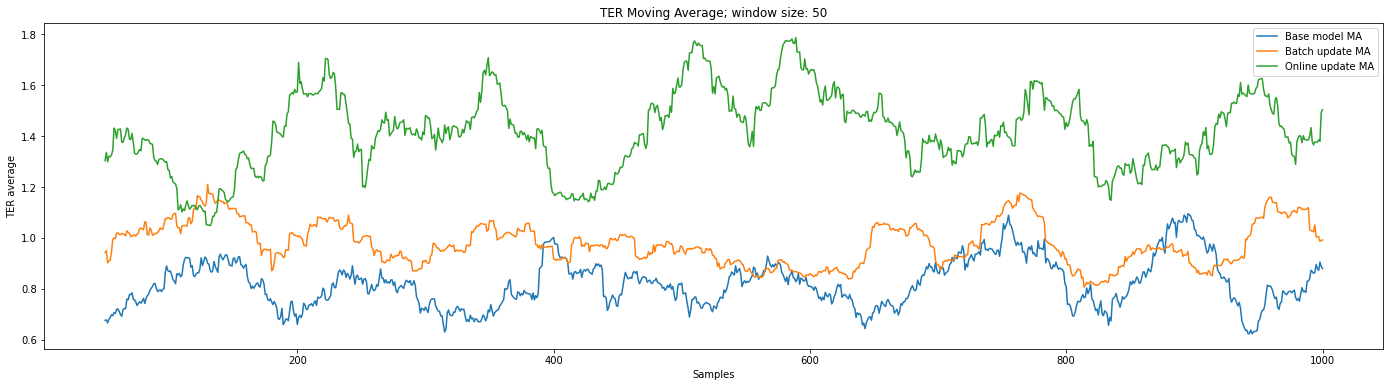

In [ ]:
  import matplotlib.pyplot as plt

  baseline_average.plot( figsize= (24,6), title= f'TER Moving Average; window size: {window_size}', label='Base model MA', xlabel= 'Samples',ylabel='TER average',legend=True )
  batch_average.plot(label= 'Batch update MA', legend=True)
  online_average.plot(label='Online update MA' ,legend=True)


## Conclusion
From the graph plot, the online model had the worst TER moving average in the long run followed by the batch updated model. The baseline model is seen to have the least TER moving average. This signifies that it had the best generalization during the training process. However, it must be known that a lot of factors are responsible for the differences in performance between this model and the research paper and some include:

- Different number of neurons,dropouts in the model's architecture: We used lesser here because of RAM space. For the dropouts, we followed a general scheme of 20% dropout.

- Different dataset: The model here was trained on 24000 samples while that in the research was pretrained on 6.6M.

- Different environmental variables in the online training mode: threshold level for cosine similarity, number of epochs and learning rate for model update on instance selection datapoints, number of epochs and learning rate for model update on each development set datapoint.